# Generative Model Evaluation: Real vs Generated Data
This notebook compares the synthetic single-cell data generated by the Flow Matching model against the held-out test dataset.

In [1]:
import torch
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import os

# Set up plotting aesthetics
sc.settings.set_figure_params(dpi=100, frameon=False, facecolor='white')
plt.rcParams['figure.figsize'] = (6, 6)

## 1. Load Data

In [ ]:
# Paths (Adjust if necessary)
REAL_DATA_PATH = "/dtu/blackhole/06/213542/paperdata/pbmc3k_train.h5ad"
GEN_DATA_PATH = "/dtu/blackhole/06/213542/paperdata/final_generated_counts_all.pt"

# 1. Load Real Data
print(f"Loading real data from {REAL_DATA_PATH}...")
adata_real = sc.read_h5ad(REAL_DATA_PATH)
X_real = adata_real.X

# Ensure dense numpy array
if hasattr(X_real, "toarray"):
    X_real = X_real.toarray()
X_real = np.asarray(X_real)

print(f"Real Data Shape: {X_real.shape}")

# 2. Load Generated Data
print(f"Loading generated data from {GEN_DATA_PATH}...")
try:
    # Assuming it was saved as a torch tensor
    X_gen_tensor = torch.load(GEN_DATA_PATH, map_location='cpu')
    X_gen = X_gen_tensor.numpy()
except Exception as e:
    print(f"Could not load as torch tensor, trying other formats. Error: {e}")
    # Fallback if saved differently (e.g. numpy or AnnData)
    # X_gen = np.load("path.npy")

print(f"Generated Data Shape: {X_gen.shape}")

# Create AnnData for Generated
adata_gen = sc.AnnData(X=X_gen)
adata_gen.var_names = adata_real.var_names  # Match gene names

Loading real data from /dtu/blackhole/06/213542/paperdata/pbmc3k_train.h5ad...
Real Data Shape: (2110, 8573)
Loading generated data from /dtu/blackhole/06/213542/paperdata/final_generated_counts.pt...
Generated Data Shape: (1000, 8573)


## 2. UMAP Visualization (Structure)

/tmp/ipykernel_1642383/3202442485.py:5: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_combined = adata_real.concatenate(adata_gen)


Preprocessing combined dataset...


/appl9/python/3.11.9/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Plotting UMAP...


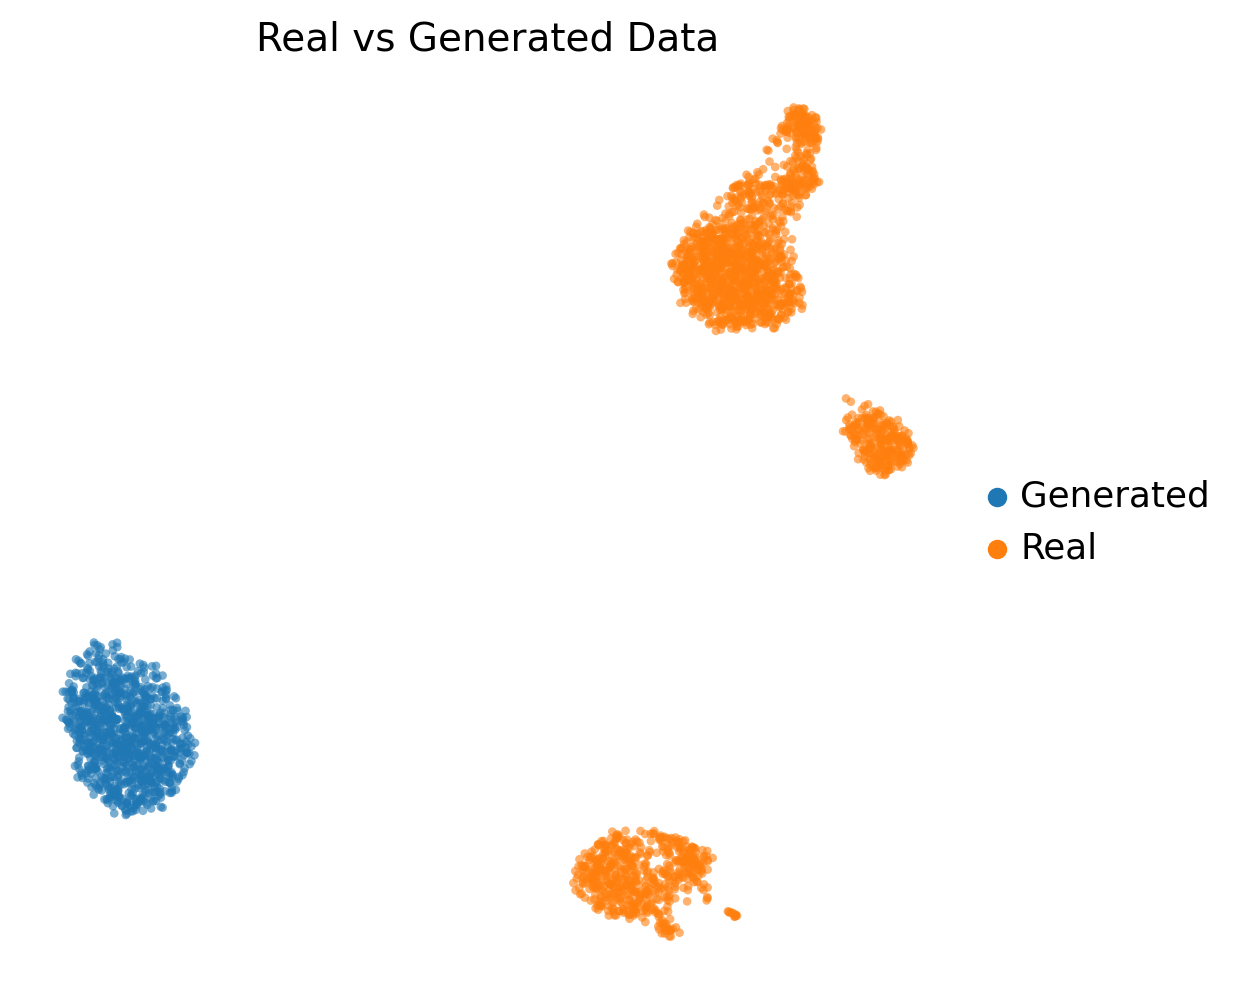

In [5]:
# Merge datasets for joint UMAP
adata_real.obs['Source'] = 'Real'
adata_gen.obs['Source'] = 'Generated'

adata_combined = adata_real.concatenate(adata_gen)

# Preprocessing
print("Preprocessing combined dataset...")
sc.pp.normalize_total(adata_combined, target_sum=1e4)
sc.pp.log1p(adata_combined)
sc.pp.highly_variable_genes(adata_combined, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.scale(adata_combined, max_value=10)
sc.tl.pca(adata_combined, svd_solver='arpack')
sc.pp.neighbors(adata_combined, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_combined)

# Plot
print("Plotting UMAP...")
sc.pl.umap(adata_combined, color='Source', alpha=0.6, title='Real vs Generated Data')

## 3. Qualitative Evaluation (Statistics)

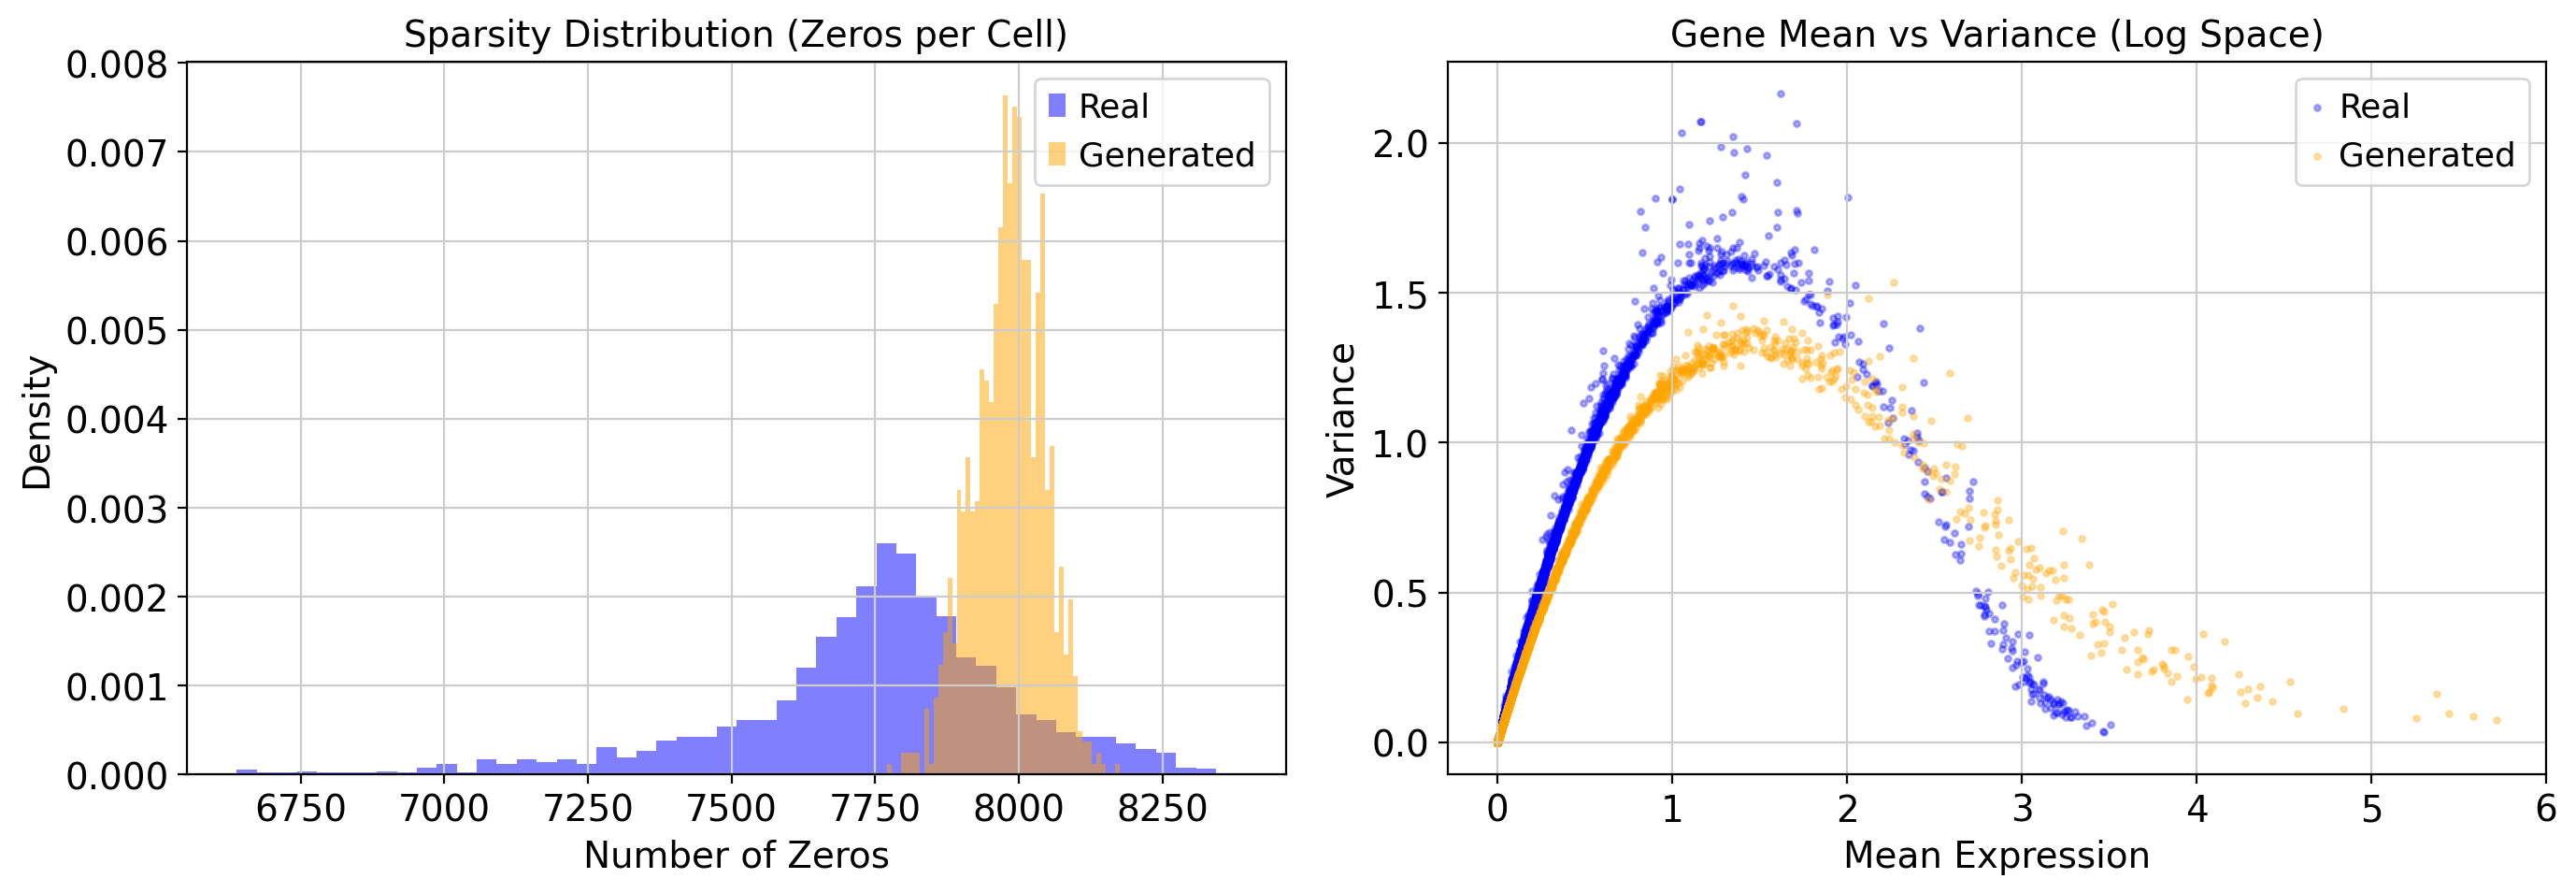

In [6]:
def plot_sparsity_and_dispersion(X_real, X_gen):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # --- 1. Sparsity (Zero counts per cell) ---
    zeros_real = (X_real == 0).sum(axis=1)
    zeros_gen = (X_gen == 0).sum(axis=1)
    
    ax[0].hist(zeros_real, bins=50, alpha=0.5, density=True, label="Real", color='blue')
    ax[0].hist(zeros_gen, bins=50, alpha=0.5, density=True, label="Generated", color='orange')
    ax[0].set_title("Sparsity Distribution (Zeros per Cell)")
    ax[0].set_xlabel("Number of Zeros")
    ax[0].set_ylabel("Density")
    ax[0].legend()

    # --- 2. Overdispersion (Mean vs Variance of Genes) ---
    # Work in Log space for better visualization
    # Normalize to 10k first to match standard practice
    def get_moments(X):
        # Simple Library Size Normalization
        X_norm = X / X.sum(axis=1, keepdims=True) * 1e4
        X_log = np.log1p(X_norm)
        return np.mean(X_log, axis=0), np.var(X_log, axis=0)

    mean_real, var_real = get_moments(X_real)
    mean_gen, var_gen = get_moments(X_gen)

    ax[1].scatter(mean_real, var_real, s=5, alpha=0.3, label="Real", color='blue')
    ax[1].scatter(mean_gen, var_gen, s=5, alpha=0.3, label="Generated", color='orange')
    ax[1].set_title("Gene Mean vs Variance (Log Space)")
    ax[1].set_xlabel("Mean Expression")
    ax[1].set_ylabel("Variance")
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

plot_sparsity_and_dispersion(X_real, X_gen)

## 4. Quantitative Metrics (MMD & Wasserstein)

In [7]:
import ot # Python Optimal Transport

def compute_quantitative_metrics(X_real, X_gen, n_pca=30, n_subsample=2000):
    print(f"Computing metrics using PCA-{n_pca} space with {n_subsample} subsamples...")
    
    # 1. PCA Projection (Fit on Real, Transform Gen)
    pca = PCA(n_components=n_pca)
    # Combine to ensure consistent space or fit on Real
    # Fitting on Real is standard for evaluation
    # Normalize first (log1p)
    X_real_log = np.log1p(X_real / X_real.sum(1, keepdims=True) * 1e4)
    X_gen_log = np.log1p(X_gen / X_gen.sum(1, keepdims=True) * 1e4)
    
    pca.fit(X_real_log)
    real_emb = pca.transform(X_real_log)
    gen_emb = pca.transform(X_gen_log)
    
    # 2. Subsample for speed (OT is O(N^2))
    idx_real = np.random.choice(len(real_emb), min(len(real_emb), n_subsample), replace=False)
    idx_gen = np.random.choice(len(gen_emb), min(len(gen_emb), n_subsample), replace=False)
    
    real_sub = real_emb[idx_real]
    gen_sub = gen_emb[idx_gen]
    
    # 3. Wasserstein Distance (Earth Mover's Distance)
    # Weights are uniform
    a, b = np.ones((len(real_sub),)) / len(real_sub), np.ones((len(gen_sub),)) / len(gen_sub)
    M = ot.dist(real_sub, gen_sub, metric='euclidean')
    w1_dist = ot.emd2(a, b, M)
    
    # 4. MMD (Maximum Mean Discrepancy) with RBF Kernel
    def rbf_kernel(x, y, sigma=1.0):
        dist_sq = np.sum((x[:, None, :] - y[None, :, :]) ** 2, axis=2)
        return np.exp(-dist_sq / (2 * sigma ** 2))

    # Use multiple bandwidths
    mmd_val = 0
    for sigma in [1, 5, 10, 20]:
        K_xx = rbf_kernel(real_sub, real_sub, sigma)
        K_yy = rbf_kernel(gen_sub, gen_sub, sigma)
        K_xy = rbf_kernel(real_sub, gen_sub, sigma)
        mmd_val += K_xx.mean() + K_yy.mean() - 2 * K_xy.mean()
    
    return np.sqrt(w1_dist), mmd_val

w1, mmd = compute_quantitative_metrics(X_real, X_gen)
print(f"Wasserstein-1 Distance (PCA Space): {w1:.4f}")
print(f"MMD Score (PCA Space): {mmd:.6f}")

ModuleNotFoundError: No module named 'ot'